# Intro to Pipelines and Pickles
> How to use transformers with sklearn's `cross_val_score` and export a machine learning model from a jupyter notebook.

<img src="https://www.polyeurope.com/site/images/home_slider/pig_animation.gif">

#### Motivations:

> We have learned how to train a machine learning model, and *we have discussed why we should never fit on our testing data*, but this becomes more complicated when we are using multiple fold cross validation ie breaking data into multiple splits. The solution for this is either a lot of manual code, or a pipeline.

>What if we wanted to deploy a model? **Currently,** our modeling process is broken up into a bunch of different code cells within a jupyter notebook, and there is no way for us to ask the model to make predictions on new data without opening the notebook, running the code to train the model, importing new data, and manually running code cells to make predictions. Google data scientists are not sitting at their computer running `shift + enter` for the thousands of data points they receive every second. So how to we use our models outside of a jupyter notebook? The solution to that is the `pickle` library.

<h3><u> Students will be able to </u></h3>

- Understand why pipelines are useful for model evaluation.
- Learn to construct a simple pipeline.
- Save a model or a pipeline as a `.pkl` file.

In [1]:
# Standard Imports
import pandas as pd
import matplotlib.pyplot as plt

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Transformers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Pipelines
from sklearn.pipeline import make_pipeline
import pickle

# Mock Data
from sklearn.datasets import load_breast_cancer
%matplotlib inline

## Let's review the modeling workflow we've seen so far...

In the cell below, we load the breast cancer dataset into a pandas dataframe:

In [2]:
data = load_breast_cancer()
df = pd.DataFrame(data['data'], columns = data['feature_names'])
df['target'] = data['target']
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


>*This particular dataset is used mostly for demonstration purposes so there is no cleaning required.* ***Normally,*** *the next step would be for us to clean and format our data so it can then be modeled. Because the data is clean, we will skip this step.*

Next, we split our data into training and testing sets.

In [3]:
# All dataset without target variable
features = df.drop('target', axis = 1)
# Isolated target variable
target = df.target

# Create two sets of data. One for training a model 
# and one for predicting on unseen data
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=2020)

Now that we have a set of data for training we can scale the data. There are many ways to scale data. Today we will use sklearn's `StandardScaler`.

In [4]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

Next we instantiate a model.

In [5]:
model = LogisticRegression(random_state=2020)

Now we use cross validation to evaluate model performance.

In [6]:
cross_val_score(model, X_train_scaled, y_train, cv=3)

array([0.98591549, 0.95070423, 0.98591549])

After we have done this, we would likely make some alterations to the data or fit other models and compare each model's performance. But let's say that we decide this is our final model. The next thing we would do is test the model on our testing data.

To do this, we fit the model to all of our training data, and evaluate performance on the testing data. 

In [7]:
model.fit(X_train_scaled, y_train)
train_preds = model.predict(X_train_scaled)
test_preds = model.predict(X_test)

In [8]:
print('Training Accuracy: ', accuracy_score(train_preds, y_train))
print('Testing Accuracy: ', accuracy_score(test_preds, y_test))

Training Accuracy:  0.9882629107981221
Testing Accuracy:  0.42657342657342656


## What did we do wrong?

- 
-

***When we scale data, the transformer should only be fit on whatever data the model is trained on.***

We can repeat the process above, leaving out `cross_val_score` and technically this would be correct.

In [9]:
# All dataset without target variable
features = df.drop('target', axis = 1)
# Isolated target variable
target = df.target

# Create two sets of data. One for training a model 
# and one for predicting on unseen data
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=2020)

# Scale training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = features.columns)

# Fit model on training data
model = LogisticRegression(random_state=2020)
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=2020)

Now if we want to use the model on testing data, *we have to transform the test data with the transformer that has been fit on the training data.*

In [10]:
X_test_scaled = scaler.transform(X_test)

Let's compare how the model performs on the unscaled and scaled testing data.

In [11]:
print('Unscaled ', model.score(X_test, y_test))
print('Scaled ', model.score(X_test_scaled, y_test))

Unscaled  0.42657342657342656
Scaled  0.9790209790209791


In [12]:
scaler.fit(features)
X = scaler.transform(features)
model.fit(X, target)

LogisticRegression(random_state=2020)

**But, what if we wanted to use multiple fold cross validation.** If the correct way to scale data is to only fit the transformer on the training data, how do we use `cross_val_score`?

Under the hood, `cross_val_score` is making splits of the data we feed into the function, training on one split and making predictions on the other. For this to work with transformers, we would need to stick a transformer into the middle of that process. 

We could choose not to use `cross_val_score` but that puts us at risk of training or testing our model on a bad sample of data. After all, when we only use a single train test split there is a possibility that our split of the data, by random chance, happened to result in an unusually high or unusually low accuracy score. We don't want that. We want to report the most representative score for our model. 

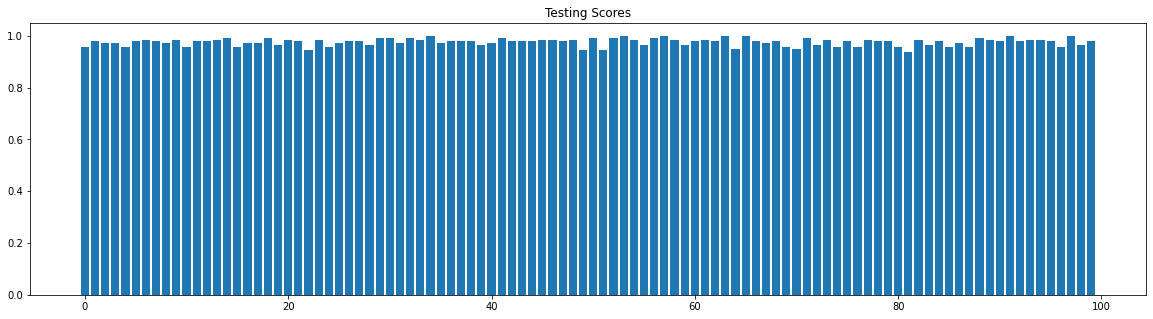

In [13]:
_test_scores = []
for i in range(100):
    _xtrain, _xtest, _ytrain, _ytest = train_test_split(features, target, random_state=i)
    _scaler = StandardScaler()
    _xtrain = _scaler.fit_transform(_xtrain)
    _xtest = _scaler.transform(_xtest)
    _model = LogisticRegression(random_state=2020)
    _model.fit(_xtrain, _ytrain)
    _test_score = _model.score(_xtest, _ytest)
    _test_scores.append(_test_score)

plt.figure(figsize=(20,5))   
plt.bar([x for x in range(len(_test_scores))], _test_scores)
plt.title('Testing Scores');

<u>In summary we need to be able to do the following:</u>
1. Access splits made by sklearn's `cross_val_score`
2. Fit the desired Transformer on the training split
3. Transform the training data
4. Fit the desired model on the training data
5. Transform the testing data with the fitted transformer <u>(Never fit on the testing data)</u>
6. Use our fitted model to make predictions on the transformed testing data.

<img src="images/cross_validation.gif" width=1000>

# Introducing sklearn's pipeline

![](https://raw.githubusercontent.com/learn-co-students/pickles-and-pipelines-seattle-ds-012720/4817cebf95395b6f10ad882bf9daac528a0650dc/visuals/transformer.gif)


With a pipeline, this code...

```python
transformer.fit(X_train)
X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)
model.fit(X_train_transformed)
model.score(X_test_transformed)
```

...instead, looks like this:

```python
pipeline.fit(X_train)
pipeline.score(X_test)
```

#### Benefits of the Pipeline

- **Convenience and encapsulation**
    - You only have to call fit and predict once on your data to fit a whole sequence of estimators.
- **Joint parameter selection**
     - You can grid search over parameters of all estimators in the pipeline at once.
- **Safety**
    - Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

Let's create a Pipeline objects to do the following:
- Scale data using `StandardScaler`
- Fit a Logistic Regression model
- Score on the testing data

Sklearn makes this process very simple with their `make_pipeline` function. 

In [14]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=2020))
pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=2020))])

Now we can feed the pipeline into sklearn's `cross_val_score`!

In [15]:
scores = cross_val_score(pipeline, X_train, y_train, cv=3)
scores

array([0.97887324, 0.95070423, 0.98591549])

And that's it! The nice thing about pipelines is that it allows us to create and easily access different modeling strategies! We can even feed pipelines into other pipelines!

In [16]:
preprocessing = make_pipeline(MinMaxScaler(), 
                              StandardScaler())

full_pipeline = make_pipeline(preprocessing, 
                              LogisticRegression(random_state=2020))                         

In [17]:
cross_val_score(full_pipeline, X_train, y_train, cv=3)

array([0.97887324, 0.95070423, 0.98591549])

In [18]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=2020))])

In [19]:
pipeline.score(X_test, y_test)

0.9790209790209791

# Pickling!

From the [documentation](https://docs.python.org/3/library/pickle.html):

>The pickle module implements binary protocols for serializing and de-serializing a Python object structure. “Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy. Pickling (and unpickling) is alternatively known as “serialization”, “marshalling,” 1 or “flattening”; however, to avoid confusion, the terms used here are “pickling” and “unpickling”.



### How to save a machine learning model

1. Use python's built in `open` function to open a new file and save the opened file to a variable
    - This function receives:
        1. The name of the file you would like to open
        2. The mode in which you would like to open the file
            - For pickle the mode is `'wb'` which stands for "write binary".
            
2. Use `pickle.dump()` 
    - Feed into this function the object you would like to save (in this case, our model) and the variable in which we have saved the opened file. 
    
3. Close the opened file by calling `.close()` on the file object.

In [20]:
pipeline.fit(features, target)

file = open('models/final_pipeline.pkl', 'wb')
pickle.dump(pipeline, file)
file.close()

### How to load a saved machine learning model

1. Use python's build in `open()` function to open the file and save the opened file to a variable.
    - Two things must be fed into this function:
        1. The path to the file
        2. The mode in which you would like to open the file. 
            - In this case, we will want to use `'rb'` which stands for "read binary".
            
2. Feed the opened file to `pickle.load()` to load in the model and save the loaded object to a variable


In [21]:
file = open('models/final_pipeline.pkl', 'rb')
saved_model = pickle.load(file)
file.close()

In [22]:
saved_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=2020))])